***
# Intro
One of the requirements of scaling support for millions of customers, means that we need to be able to help our agents triage incoming tickets through meaningful queues and prioritisation in real time. In order to achieve this, we use ```labels``` that we call ```“contact reasons”``` to ```classify``` incoming ```tickets``` and reflect why a customer is reaching out for help.

You’ve been tasked with helping your team
```develop a solution``` for ```classifying``` incoming support ```tickets```.

Our goal is to have a way to ```output``` the correct ```contact reason``` ```based off``` of the support ```ticket content```
***

***
**Dataset**

We’ve provided you with two mock datasets to work with.
1. The first dataset includes publicly available reviews of our app coming from the
    Apple Store, Google Store and TrustPilot reviews.
```They are not labelled```

2. The second is a list of customer service tickets with a label attached to it.
```The label is the contact reason for the ticket.```
***

***
**Tasks**
1. Using the ```customer_reviews.csv``` set, please ```provide``` and test ```data cleaning``` ideas. We are interested in your preprocessing skills and how you would do this at scale.

2. The ```customer_tickets.csv``` set has already been cleaned by your colleague. Use this dataset to ```classify each ticket``` with a ```contact reason``` label using an algorithm/-s of your choice.
   <br>The list of labels can be found in the ```contact_reason_labels.csv```

*Hint: You can use any available and ready-to-go solutions, i.e. packages/cleaning
tools/embeddings/models etc.*
***

# Understanding the task
We've been asked to make solutions to:
<br>1) Data cleaning (raw data transformation into a state suitable for NLP models to work (customer_reviews.csv))
<br>2) Classification of each ticket with a contact reason (NLP multi-class text clasification (customer_tickets.csv, contact_reason_labels.csv))

# Data cleaning

We have:
1. 'customer_reviews.csv' - new items with unprocessed raw text data in them (need to process/clean)
2. 'customer_tickets.csv' - known items with preprocessed text data (so we can train from it a model)
3. 'contact_reason_labels.csv' - target labels for known items in 'customer_tickets.csv'

In [1]:
import pandas as pd

# reusables
def df_check(df:pd.DataFrame, values_length_trshld)->pd.DataFrame:
    res = \
    pd.concat([df.isna().agg(['sum']).rename({'sum':'NA'}).T,
               (~df.isna()).agg(['sum']).rename({'sum':'not-NA'}).T,
               (df=='').agg(['sum']).rename({'sum':'empty'}).T,
              #  df.map(lambda x: len(str(x))<values_length_trshld).agg(['sum']).rename({'sum':f'length<{values_length_trshld}'}).T
               df.applymap(lambda x: len(str(x))<values_length_trshld).agg(['sum']).rename({'sum':f'length<{values_length_trshld}'}).T
              ],
              axis=1
             )
    return res

In [2]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/TradeRepublic/')

Mounted at /content/drive


***
## **customer_reviews.csv** as "df_0", Raw text processing/cleaning
***

In [3]:
df_0 = pd.read_csv('customer_reviews.csv')
print(df_0.head())

                                     CUSTOMER_REVIEW
0  \n June 13, 2023\n★★☆☆☆\n\n**I hate the latest...
1  \n [UPD] June 14, 2023 ★☆☆☆☆\n\nHabe nun oft P...
2  \n June 16, 2023\n★★★★☆\n\nzu wenig Derivate\n...
3  \n June 15, 2023\n★☆☆☆☆\n\n**Don’t invest!!!!*...
4   ![](https://images-static.trustpilot.com/api/...


In [4]:
df = df_0
print('DataFrame.info()'); print(df.info(verbose=True),'\n')
print('DataFrame.describe()'); print(df.describe(),'\n')
print('custom checks'); print(df_check(df, 20).to_string(),'\n')

DataFrame.info()
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1432 entries, 0 to 1431
Data columns (total 1 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   CUSTOMER_REVIEW  1432 non-null   object
dtypes: object(1)
memory usage: 11.3+ KB
None 

DataFrame.describe()
                                          CUSTOMER_REVIEW
count                                                1432
unique                                               1432
top     \n June 13, 2023\n★★☆☆☆\n\n**I hate the latest...
freq                                                    1 

custom checks
                 NA  not-NA  empty  length<20
CUSTOMER_REVIEW   0    1432      0          0 



In [5]:
print(df_0.iloc[0:20,:].to_string())

***
**What do I see:**
1. Data from different sources (App Store, Google Play, Trustpilot...) -> the structures are different (Trustpilot for sure) and so the rules for processing (full structure (all possible fields) reverse engineering from here is a bad idea because we cannot have much guarantees of quality. We can extract a lot, but better to do it on a data pipe that has direct access to the data sources because the real structure defined there)
2. in 16 and 17 we have reviews from Trustpilot and data doubled inside (perhaps it was editing|updating) -> will need to carefully cut out substrings
3. Non-english -> translate to English to operate NLP in the space of one vocabulary
***
*Ideas for future?*
<br>Additional parameters can be extracted and used as auxiliaries (alongside with the classification of 'contact reasons') for the quality of company's service, but for this we will need to dig into the structure of each of sources of reviews (like 'Stars' -> can be used for additional priority ranking). But I think it's better not to do it with this file but rather on the data pipe that has direct access to the source and it's structure (is it DB, API?)
***

In [6]:
# what other sources we have?
print('Unknown source!')
print(df_0[ ~ df_0['CUSTOMER_REVIEW'].map(
    lambda x: (
        ('Google Play' in x) or
        ('App Store' in x) or
        ('trustpilot' in x)
    )
)].to_string())

Unknown source!
                                                CUSTOMER_REVIEW
60    The review was deleted\n\n\n ![]()\nwww.traderepublic.com
1387                               ![]()\nwww.traderepublic.com


***
I would offer to leftout this in case of "production", such items shell not pass to NLP model because of unpredictable behaviour of the latter (and 'empty' cases will be classified as the most probable class (just because it is the most probablistic class by priori from it's size, but since they are empty they are most likely unusefull to process in real business))
***

***
Let's look closer to cases which we will need to process.

For each different source we need one example with shortest review and one with the longest.

So that we can suggest appropriate preprocessing for each source wrt to it's structure divercity of content provided.
***

In [7]:
map_known_sources_parcing = {
    'Google Play' :'google_play',
    'App Store'   :'app_store',
    'trustpilot'  :'trustpilot'
}

df_0['source'] = df_0['CUSTOMER_REVIEW'].apply(
    lambda x: (
            ([v for (k,v) in map_known_sources_parcing.items() if k in x]+['unknown'])[0]
    )
)

df = df_0.copy()
df['text_length'] = df['CUSTOMER_REVIEW'].apply(len)
df = \
    pd.concat([
        df.loc[df.drop_duplicates(['source','text_length']).groupby('source')['text_length'].idxmax()],
        df.loc[df.drop_duplicates(['source','text_length']).groupby('source')['text_length'].idxmin()]
    ]).sort_values(['source','text_length'])
print(df.to_string())

***
To process known 3 sources we will use 'anchors' with individual logic to cut out the usefull part of the review:

2. **'trustpilot':**
   <br>*last '\n\n\n' = headline of the review*
   <br>*first '\n\n' after last '\n\n\n' = message*
   <br>```rule: cut from last '\n\n\n' up until the end of the string```
3. **'google_play':**
   <br>```rule: cut from last ('☆\n\n')OR('★\n\n') up until following '\n\n By'```
4. **'app_store':**
   <br>```rule: cut from last ('☆\n\n')OR('★\n\n') up until following '\n\n By'```
***

In [8]:
def preproc_textcutter_reviews(x:pd.Series)->str:
    src = x['source']
    rvw = x['CUSTOMER_REVIEW']

    if src in ['google_play',
               'app_store']:
        ind_c = max(rvw.rfind('☆\n\n'), rvw.rfind('★\n\n'))
        if ind_c != -1: #or else return original (but for production it's better to put it off as we did with 'unknown' source, coz in this case we didn't make good recognition of the structure and anchors)
            ind_c += len('★\n\n') #len=3 btw
            rvw = rvw[ind_c:]
        ind_c = rvw.find('\n\n By')
        if ind_c != -1: #or else return original (but for production it's better to put it off as we did with 'unknown' source, coz in this case we didn't make good recognition of the structure and anchors)
            rvw = rvw[:ind_c]
        res = rvw

    elif src == 'trustpilot':
        ind_c = rvw.rfind('\n\n\n')
        if ind_c != -1: #or else return original (but for production it's better to put it off as we did with 'unknown' source, coz in this case we didn't make good recognition of the structure and anchors)
            ind_c += len('\n\n\n') #len=3
            rvw = rvw[ind_c:]
        res = rvw
    else:
        res = rvw # we can raise baseexception here, or erase, or return asis (must be dropped all rows from 'unknown' src at this point!)
    return res

In [9]:
print(df_0[0:1].apply(preproc_textcutter_reviews, axis=1).values[0])

**I hate the latest update**

I am sure the dev worked hard on this downgrade, but I strongly disagree with the designers choices and I am so sad. It feels like everything is way too big and dumbed down, and it takes me much more effort and more gestures in order to re-do the work flow on the app I had before the update. And what’s up with those unreadable baby charts? It’s ridiculous! Please upgrade me back to the previous version 😔


In [10]:
print(df_0[0:1].values[0,0])


 June 13, 2023
★★☆☆☆

**I hate the latest update**

I am sure the dev worked hard on this downgrade, but I strongly disagree with the designers choices and I am so sad. It feels like everything is way too big and dumbed down, and it takes me much more effort and more gestures in order to re-do the work flow on the app I had before the update. And what’s up with those unreadable baby charts? It’s ridiculous! Please upgrade me back to the previous version 😔

 By Person66890274 · App Store · v1.154 · Country: France · Detect language: English · Stats: 82 words
https://watch.appfollow.io/apps/trade-republic/reviews/291557?review_id=330304890

 ![](https://email.appfollow.io/o/eJwEwEuOwyAMANDThN0gcBzbs-AwDjZq1LSgfFSpp--zosDqwUsmIQYGpPAoBAtJQ5FsGWWpUIWVzev_mhkXC1uBBHOijIkhIUZoMBO2VTw3U9IJk47R-r73T9x6OMp5j9GPa8J0HX9-x6-_zc9nrP31CwAA__9oyycj)


***
looks good. Let's check min max cases wrt sources again
***

In [11]:
df = df_0.copy()
df['text_length'] = df['CUSTOMER_REVIEW'].apply(len)
df = \
    pd.concat([
        df.loc[df.drop_duplicates(['source','text_length']).groupby('source')['text_length'].idxmax()],
        df.loc[df.drop_duplicates(['source','text_length']).groupby('source')['text_length'].idxmin()]
    ]).sort_values(['source','text_length'])
df['CUSTOMER_REVIEW'] = df.apply(preproc_textcutter_reviews, axis=1)
print(df.to_string())

***
Looks okay. Apply.
***

In [12]:
df_0['CUSTOMER_REVIEW'] = df_0.apply(preproc_textcutter_reviews, axis=1)

***
It much cheaper (from model perspective) and efficient (by vocab size) to use one language. And for the internal team too.

Let's translate everything to English (it might be better to detect non-English cases, since we have 'detected language' insight for 2 sources (google,apple), but since no guarantees by default and also trustpilot does not has such an insight - let's do it for all data)
***

In [13]:
!pip install translators
import translators as ts
try:
    _ = ts.preaccelerate_and_speedtest()
except: pass

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.4/56.4 kB 1.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.9 MB/s eta 0:00:00
  Created wheel for PyExecJS: filename=PyExecJS-1.5.1-py3-none-any.whl size=14578 sha256=8e5cd646280ea16ec04d7a28232d858c3448cf4164c2b252b80216c9af0f5244
  Stored in directory: /root/.cache/pip/wheels/9d/91/30/28e6da53d4f44dc445349b2ffad581968447e4cbc9dd7991b8
Successfully built PyExecJS


Preacceleration-Process will take a few minutes.
Tips: The smaller `timeout` value, the fewer translators pass the test and the less time it takes to preaccelerate. However, the slow speed of preacceleration does not mean the slow speed of later translation.

Preacceleration Process: 100%|██████████████████| 37/37 [06:13<00:00, 10.09s/it]


SpeedTest-Process will take a few seconds.

SpeedTest Process:  15%|███▊                     | 4/26 [00:03<00:20,  1.09it/s]TimeSpent(function: bing): 0.05s
TimeSpent(function: caiyun): 0.51s
SpeedTest Process: 100%|████████████████████████| 26/26 [02:03<00:00,  4.74s/it]


In [14]:
print(df_0.loc[1331].iloc[0]) #bing fastest and good on detecting different languages
print(ts.translate_text(query_text=df_0.loc[1331].iloc[0],translator='bing',from_language='auto',to_language='en'))
print(df_0.loc[8].iloc[0])
print(ts.translate_text(query_text=df_0.loc[8].iloc[0],translator='bing',from_language='auto',to_language='en'))

**Guthabenverzinsung**

👍🏿👍🏿👍🏿
**Interest on balances**

👍🏿👍🏿👍🏿
Mit dem letzte großen update schöecht geworden, graph stimmt nicht und was spll die weiße farbe??
With the last big update became beautiful, graph is not correct and what spll the white color??


In [15]:
def restack_lststr_bylenlim_preferable(txt:str,lenlim:int=500)->list:
    '''
    we need this for meaningfull chunking (to further passing to translator api)
    we slicing by sentences using ('.' sep) with preferable length 'lenlim'
    '''
    t_spl = txt.split('.')
    last_stc_ss = t_spl[0]
    if len(t_spl)==1:
        res = [last_stc_ss,]
        return res
    res = []
    t_spl = t_spl[1:]
    for i,ss in enumerate(t_spl,1):
        if last_stc_ss == '':
            last_stc_ss = ss
        else:
            last_stc_ss = '.'.join([last_stc_ss, ss])
        if len(last_stc_ss) >= lenlim:
            res.append(last_stc_ss)
            last_stc_ss = ''
        if i == len(t_spl):
            res.append(last_stc_ss)
    return res

In [16]:
# wrote a chunker 'restack_lststr_bylenlim_preferable', coz 1000 symbols is often the upper limit per request
# go through EACH chunk for each row separately and brute force it for 100 trials there per chunk with sleep timeout 61 sec
# 60retries * 60secs =1 hour to try
import time

df = df_0.copy(True)

def translate_call(t, retries_lim:int=59, timeout_retry_sec:int=61):
    try_cntr = 1
    try_limit = retries_lim #60retries * 60secs =1 hour to try
    e_loop = None
    while try_cntr <= try_limit:
        try:
            res = ts.translate_text(query_text=t,translator='bing', from_language='auto', to_language='en')
            break
        except Exception as e:
            e_loop = e
            try_cntr += 1
            time.sleep(timeout_retry_sec) #61 second timeout at least (requests per time limit exists)
    if try_cntr > try_limit:
        raise ValueError('We got a problem with the translator: ', repr(e))
    return res

df['CUSTOMER_REVIEW'] = \
df['CUSTOMER_REVIEW'].apply(lambda x: restack_lststr_bylenlim_preferable(x,500) # chunk by length to list of sentences each element in Series
                           ).apply(lambda x: [translate_call(t,retries_lim=59,timeout_retry_sec=61) #translate them one by one
                                              for t in x]).apply(lambda x: '.'.join(x)) # join translated chunks of sentences

In [17]:
print(df_0.loc[8].iloc[0])
df_0 = df.copy(True)
print(df_0.loc[8].iloc[0])

Mit dem letzte großen update schöecht geworden, graph stimmt nicht und was spll die weiße farbe??
With the last big update became beautiful, graph is not correct and what spll the white color??


***
Good. Now emoji.

Nowadays the best approach is to use pretrained base-model like BERT for NLP (previously we were used to simpler embeddings). And we actually have pretrained mods of them which seen emoji and can handle them. And my recommendation would be to use them since we have emoji, and moreover some reviews have emoji only!

But, just in case, I will leave the code below to be able to replace them by words if someone would like to go classy with freq-like vocab models.
***

In [18]:
!pip install emoji
import emoji

###################
# switch to words
df = df_0.copy(True)
print(df.loc[1331].iloc[0])
df['CUSTOMER_REVIEW'] = df['CUSTOMER_REVIEW'].apply(lambda x: emoji.demojize(x, delimiters=(':',':'), language='en'))
print(df.loc[1331].iloc[0])

print()

###################
# or just clear them
df = df_0.copy(True)
print(df.loc[1331].iloc[0])
df['CUSTOMER_REVIEW'] = df['CUSTOMER_REVIEW'].apply(lambda x: emoji.replace_emoji(x, ''))
print(df.loc[1331].iloc[0])

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 431.4/431.4 kB 6.7 MB/s eta 0:00:00
**Interest on balances**

👍🏿👍🏿👍🏿
**Interest on balances**

:thumbs_up_dark_skin_tone::thumbs_up_dark_skin_tone::thumbs_up_dark_skin_tone:

**Interest on balances**

👍🏿👍🏿👍🏿
**Interest on balances**




***
It also can be applied:
1. Lower case (strongly narrowing the size of vocab. used even in pretrained transformers with '-uncase' postfix in their namings)
2. Removing punctuation (in older models like frequency-based (BOW) we must not use punctuation for sure)
3. Remove stop words (mostly words that are too unique or too frequent)
4. Stemming / lemmatization (simplifying the words)

But again, if we can use BERT-like base models - we don't need it. With such a pretrained models we have big vocabulary and  high-quality similarity coverage in an embedded feature space that leads to good generalization without simplifying tokens and narrowing vocab.

*(yeah I'm gonna use BERT in next section to make a showcase)*

but if we would need it.. they are below.
***

In [19]:
!pip install nltk

df = df_0.copy(True)

###################
# lowering case
df['CUSTOMER_REVIEW'] = df['CUSTOMER_REVIEW'].apply(lambda x: x.lower())
print('lowering case')
print(df.head())

###################
# remove punctuation
import string
punct = string.punctuation
def remove_punctuation(text_sentence):
    text = "".join([word for word in text_sentence if word not in punct])
    return text
df['CUSTOMER_REVIEW'] = df['CUSTOMER_REVIEW'].apply(lambda x: remove_punctuation(x))
print('\nremove punctuation')
print(df.head())

###################
# tokenize (split)
import re
def tokenize_split(text_sentence):
    token = re.split('\W+', text_sentence)
    return token
df['CUSTOMER_REVIEW'] = df['CUSTOMER_REVIEW'].apply(lambda x: tokenize_split(x))
print('\ntokenize (split)')
print(df.head())

###################
# remove stop-words
import nltk
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('english')
def remove_stopword(text_sentence):
    text = [word for word in text_sentence if word not in stopwords]
    return text
df['CUSTOMER_REVIEW'] = df['CUSTOMER_REVIEW'].apply(lambda x: remove_stopword(x))
print('\nremove stop-words')
print(df.head())

###################
# Stemming / lemmatization
ps = nltk.PorterStemmer()
def stemming(text_sentence):
    text = [ps.stem(word) for word in text_sentence]
    return text
df['CUSTOMER_REVIEW'] = df['CUSTOMER_REVIEW'].apply(lambda x : stemming(x))
print('\nStemming / lemmatization')
print(df.head())

lowering case
                                     CUSTOMER_REVIEW       source
0  **i hate the latest update**\n\ni am sure the ...    app_store
1         i now often have problems opening the app.  google_play
2                                too few derivatives  google_play
3  **don’t invest!!!! **\n\ninvesting works fine ...    app_store
4  do not transfer your money to trade…\n\ndo not...   trustpilot

remove punctuation
                                     CUSTOMER_REVIEW       source
0  i hate the latest update\n\ni am sure the dev ...    app_store
1          i now often have problems opening the app  google_play
2                                too few derivatives  google_play
3  don’t invest \n\ninvesting works fine enough b...    app_store
4  do not transfer your money to trade…\n\ndo not...   trustpilot

tokenize (split)
                                     CUSTOMER_REVIEW       source
0  [i, hate, the, latest, update, i, am, sure, th...    app_store
1  [i, now, often, have,

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.



remove stop-words
                                     CUSTOMER_REVIEW       source
0  [hate, latest, update, sure, dev, worked, hard...    app_store
1                    [often, problems, opening, app]  google_play
2                                      [derivatives]  google_play
3  [invest, investing, works, fine, enough, withd...    app_store
4  [transfer, money, trade, transfer, money, trad...   trustpilot

Stemming / lemmatization
                                     CUSTOMER_REVIEW       source
0  [hate, latest, updat, sure, dev, work, hard, d...    app_store
1                        [often, problem, open, app]  google_play
2                                            [deriv]  google_play
3  [invest, invest, work, fine, enough, withdraw,...    app_store
4  [transfer, money, trade, transfer, money, trad...   trustpilot


***
**Additional ideas how to apply LLMs/transformers:**
1. **we could summarize or enrich (by ghost-word-masking) sentences** (theoretically that would optimize the description of each item for more generalized inference (more correlated in feature space of tokens from learned vocabulary from summarized/enriched samples in train data)).
2. **upsmapling: we could synthesize similar sentences within classes to train models better**
***

***
## **'customer_tickets.csv'** as df_1
***

In [20]:
df_1 = pd.read_csv('customer_tickets.csv')
df_1.head()

,text,label
0,I am still waiting on my card?,11
1,What can I do if my card still hasn't arrived ...,11
2,I have been waiting over a week. Is the card s...,11
3,Can I track my card while it is in the process...,11
4,"How do I know if I will get my card, or if it ...",11


In [21]:
df = df_1
print('DataFrame.info()'); print(df.info(verbose=True),'\n')
print('DataFrame.describe()'); print(df.describe(),'\n')
print('custom checks'); print(df_check(df, 13).to_string(),'\n')

DataFrame.info()
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13083 entries, 0 to 13082
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    13083 non-null  object
 1   label   13083 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 204.5+ KB
None 

DataFrame.describe()
              label
count  13083.000000
mean      37.733700
std       22.352789
min        0.000000
25%       18.000000
50%       37.000000
75%       57.000000
max       76.000000 

custom checks
       NA  not-NA  empty  length<13
text    0   13083      0          0
label   0   13083      0      13083 



In [22]:
print(df_1.iloc[0:20,:].to_string())

                                                                                             text  label
0                                                                  I am still waiting on my card?     11
1                                    What can I do if my card still hasn't arrived after 2 weeks?     11
2                                      I have been waiting over a week. Is the card still coming?     11
3                                     Can I track my card while it is in the process of delivery?     11
4                                          How do I know if I will get my card, or if it is lost?     11
5                                                               When did you send me my new card?     11
6                                                    Do you have info about the card on delivery?     11
7                                          What do I do if I still have not received my new card?     11
8                                                    Do

In [23]:
print('unique labels:', len(set(df_1['label'])))

unique labels: 77


In [24]:
print(df_1[df_1['label']==0].iloc[0:20,:].to_string())

                                                                   text  label
9179                   Please help me with my card.  It won't activate.      0
9180                         I tired but an unable to activate my card.      0
9181                                     I want to start using my card.      0
9182                                       How do I verify my new card?      0
9183          I tried activating my plug-in and it didn't piece of work      0
9184                                          How do i activate my card      0
9185                     Can someone assist me with activating my card?      0
9186                                     My card needs to be activated.      0
9187                                  I was unable to activate my card.      0
9188  Is my card ready for use or does it need activated and if so how?      0
9189                                      Help me activate my new card.      0
9190                    Do I need a photo ID to acti

***
## **'contact_reason_labels.csv'** as df_2
***

In [25]:
df_2 = pd.read_csv('contact_reason_labels.csv')
df_2.head()

,label\tintent (category)
0,0\tactivate_my_card
1,1\tage_limit
2,2\tapple_pay_or_google_pay
3,3\tatm_support
4,4\tautomatic_top_up


In [26]:
df = df_2
print('DataFrame.info()'); print(df.info(verbose=True),'\n')
print('DataFrame.describe()'); print(df.describe(),'\n')
print('custom checks'); print(df_check(df, 11).to_string(),'\n')

DataFrame.info()
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77 entries, 0 to 76
Data columns (total 1 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   label	intent (category)  77 non-null     object
dtypes: object(1)
memory usage: 744.0+ bytes
None 

DataFrame.describe()
       label\tintent (category)
count                        77
unique                       77
top         0\tactivate_my_card
freq                          1 

custom checks
                          NA  not-NA  empty  length<11
label\tintent (category)   0      77      0          0 



In [27]:
print('unique labels:', len(set(df_2.iloc[:,0])))

unique labels: 77


In [28]:
print(df_2.iloc[0:76,:].to_string())

                               label\tintent (category)
0                                   0\tactivate_my_card
1                                          1\tage_limit
2                            2\tapple_pay_or_google_pay
3                                        3\tatm_support
4                                   4\tautomatic_top_up
5            5\tbalance_not_updated_after_bank_transfer
6   6\tbalance_not_updated_after_cheque_or_cash_deposit
7                            7\tbeneficiary_not_allowed
8                                    8\tcancel_transfer
9                               9\tcard_about_to_expire
10                                  10\tcard_acceptance
11                                     11\tcard_arrival
12                           12\tcard_delivery_estimate
13                                     13\tcard_linking
14                                 14\tcard_not_working
15                         15\tcard_payment_fee_charged
16                      16\tcard_payment_not_rec

***
I can see a lot of card-, cash-, transfer- customers problems labels.
<br>But I've seen a lot reviews about the mobile app and we don't have such a label to collect a queue for such case.
<br>I would make one.
<br>**Also, probably it would be a good idea to make a second labels (additionally to these) by "topic modelling" with clusters number chosen from "elbow analysis". So that we would be more adaptable to customers real latest needs.**
***

<Axes: ylabel='text'>

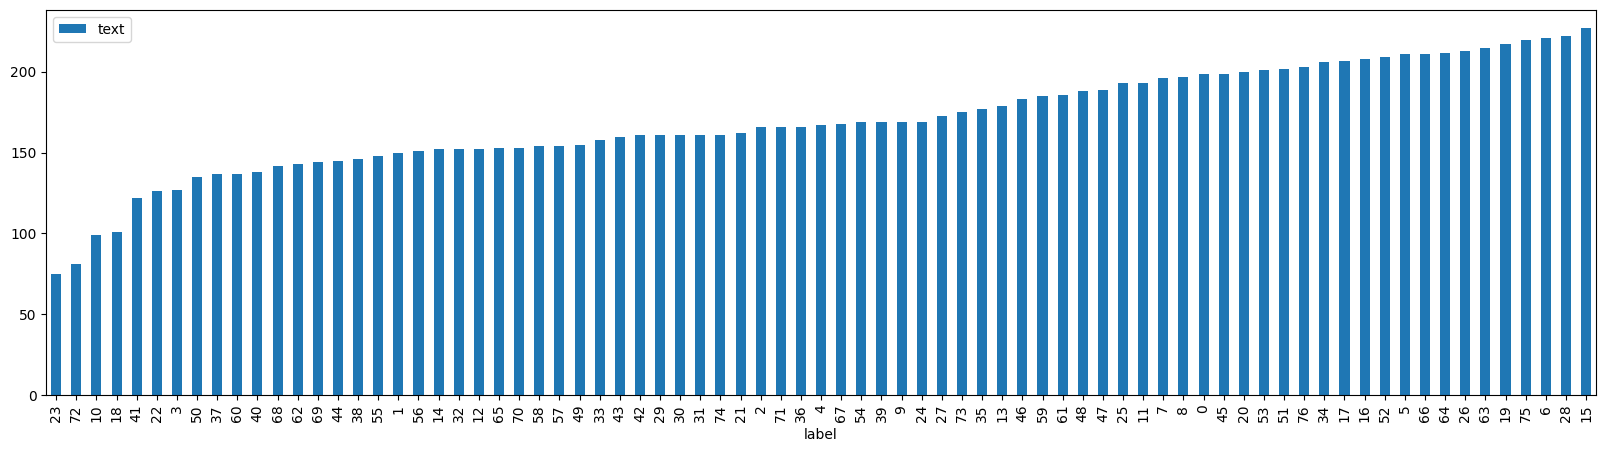

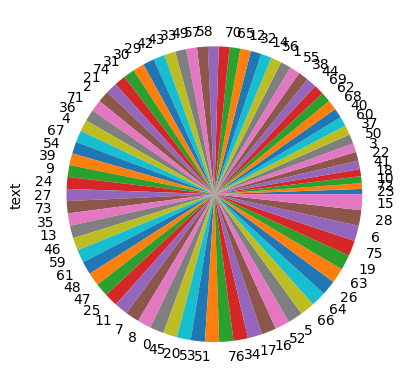

In [29]:
df_1.groupby(by='label').count().sort_values('text').plot(kind='bar', figsize=(20,5) )
df_1.groupby(by='label').count().sort_values('text').plot(kind='pie', y='text', legend=False)

***
class imbalance is not a huge problem at this time, but still may be taken into account on training phase (e.g. SMOTE)

rather.. the length of training examples might be to small wrt number of classes (classes must be distinguishable and we need more tokens per item for that)
***

# Classification of each ticket with a contact reason

***
We will use pretrained uncased BERT model for English to make a modern text classificator.
<br>
It is Contextual and Bidirectional. (trained on masked language modeling (MLM) and next sentence prediction (NSP))
<br>It has great generalization and prediction abilities since it pretrained on big textual data.
<br>...other transformers exists, e.g. even that understands emojis 😊
***

In [30]:
!pip install transformers
!pip install tensorflow
!pip install tf_keras
# tf 2.16+ comes with Keras 3, but we need Keras 2 for Bert (tf_keras)
import gc
import os
os.environ["TF_USE_LEGACY_KERAS"] = "1" # before importing tensorflow, will switch TF to Keras 2 (instead of included Keras 3 by default, need for BERT)
import tensorflow as tf
import transformers
from transformers import TFAutoModel, AutoTokenizer
from sklearn.model_selection import train_test_split
import numpy as np
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras import callbacks
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score

In [31]:
def regular_encode(texts, tokenizer, maxlen=512):
    """
    encodes text for a model
    """
    enc_di = tokenizer.batch_encode_plus(
        texts,
        return_token_type_ids = False,
        padding = 'max_length',
        max_length = maxlen,
        truncation=True
    )
    return np.array(enc_di['input_ids'])

def build_model(transformer, max_len=512, hidden_dim=32, n_classes=1):
    """
    builds a model
    """
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    # sequence_output = transformer(input_word_ids)[0] #(last_hidden_state, pooler_output, )
    sequence_output = transformer(input_word_ids).last_hidden_state
    cls_token = sequence_output[:, 0]
    # classification token [CLS] (BERT has been trained for MASK and CLS simultaneously)
    # [CLS] as a token is a good representation for sentence-level classification (i.e. it's emedding)
    # shape is [batch_size, tokens, hidden_dim] i.e. we need [:,0] as [CLS] is the first one

    if n_classes == 2: # binary classification
        out = Dense(1, activation = 'sigmoid')(cls_token)
    else: # multiclass
        out = Dense(n_classes, activation = 'softmax')(cls_token)

    model = Model(inputs = input_word_ids, outputs=out)

    # FREEZE if we would like to build more complex NN head (shallow linear+softmax is not enough) rather than refinetune BERT
    # transformer.trainable = False

    if n_classes == 2:
        model.compile(Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
    else:
        model.compile(Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [32]:
print('mean sentence length: ', int(df_1['text'].apply(len).mean()))
print('max sentence length: ', int(df_1['text'].apply(len).max()))

mean sentence length:  58
max sentence length:  433


In [33]:
#tf reset routines for restarting multiple times (to prevent duplicating graph and memory leakage)
strategy = None
model = None
transformer_layer = None
del strategy
del model
del transformer_layer

#tf.compat.v1.reset_default_graph()
tf.keras.backend.clear_session() # reset_default_graph is called inside
_ = gc.collect()
del _



strategy = tf.distribute.get_strategy()
AUTO = tf.data.experimental.AUTOTUNE

# Configuration
EPOCHS = 20 #2 # 4
BATCH_SIZE = 32 * strategy.num_replicas_in_sync
MAX_LEN = 58 #512 is max for bert-base-uncased, but average is ok (58 in our case)
MODEL = 'bert-base-uncased' # use any appropriate model (e.g. bert-base-cased) from https://huggingface.co/models

In [34]:
# load tokenizer from selected MODEL
tokenizer = AutoTokenizer.from_pretrained(MODEL) #, use_fast=False)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [35]:
%%time

x_all, y_all = df_1['text'].values, df_1['label'].values
x_train, x_test, y_train, y_test = train_test_split(x_all, y_all,
                                                    test_size = 0.3, #70% to train
                                                    stratify = y_all, random_state = 32)
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test,
                                                    test_size = 0.5, # the rest for 50/50 val/tst
                                                    stratify = y_test, random_state = 32)

x_train_enc = regular_encode(list(x_train), tokenizer, maxlen=MAX_LEN)
x_test_enc = regular_encode(list(x_test), tokenizer, maxlen=MAX_LEN)
x_val_enc = regular_encode(list(x_val), tokenizer, maxlen=MAX_LEN)

# encode textual labels into corresponding numbers (we already have numbers, but okay, just to showcase)
encoder = LabelEncoder()
encoder.fit(y_all)
encoded_y_train = encoder.transform(y_train)
encoded_y_val = encoder.transform(y_val)
# convert integers to dummy variables (one hot encoded)
dummy_y_train = to_categorical(encoded_y_train, num_classes = len(set(y_all)))
dummy_y_val = to_categorical(encoded_y_val, num_classes = len(set(y_all)))

CPU times: user 1.78 s, sys: 142 ms, total: 1.92 s
Wall time: 2.3 s


In [36]:
# build tensorflow's DataSet object
train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((x_train_enc, dummy_y_train))
    .repeat()
    .shuffle(2048)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

test_dataset = (
    tf.data.Dataset
    .from_tensor_slices(x_test_enc)
    .batch(BATCH_SIZE)
)

val_dataset = (
    tf.data.Dataset
    .from_tensor_slices((x_val_enc, dummy_y_val))
    .shuffle(2048)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

rlp = callbacks.ReduceLROnPlateau(monitor='val_loss', patience=1, verbose=1, factor=0.1)
es = callbacks.EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True, min_delta=1e-4)

In [37]:
%%time
with strategy.scope():
    transformer_layer = TFAutoModel.from_pretrained(MODEL)
    model = build_model(transformer_layer, max_len=MAX_LEN, n_classes=len(set(y_all)))
model.summary()

# warnings is normal. we got them coz we placed our own 'head'(with sigmoids) after [cls] output
# (and droped off existed part after [cls] provided with the base-model,
# we don't need it, since we building from cls as from embedding our own 'head' for multi-class classification)

# and IF we freezed base-model to speed up wo refinetune it with more complex custom NN head over it:
for l in model.layers:
    print(f'{l.trainable} <- trainable? {l.name}')

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_word_ids (InputLayer  [(None, 58)]              0         
 )                                                               
                                                                 
 tf_bert_model (TFBertModel  TFBaseModelOutputWithPo   109482240 
 )                           olingAndCrossAttentions             
                             (last_hidden_state=(Non             
                             e, 58, 768),                        
                              pooler_output=(None, 7             
                             68),                                
                              past_key_values=None,              
                             hidden_states=None, att             
                             entions=None, cross_att             
                             entions=None)                   

In [ ]:
# Train

n_steps = max(1, x_train_enc.shape[0] // BATCH_SIZE) # steps per epoch

train_history = model.fit(
    train_dataset,
    validation_data = val_dataset,
    steps_per_epoch = n_steps,
    epochs = EPOCHS,
    callbacks = [rlp, es],
)

Epoch 1/20


286/286 [==============================] - 202s 448ms/step - loss: 2.6770 - accuracy: 0.3780 - val_loss: 0.5092 - val_accuracy: 0.8563 - lr: 1.0000e-04
Epoch 2/20
286/286 [==============================] - 120s 418ms/step - loss: 0.3767 - accuracy: 0.8938 - val_loss: 0.3706 - val_accuracy: 0.8940 - lr: 1.0000e-04
Epoch 3/20
286/286 [==============================] - 119s 416ms/step - loss: 0.2020 - accuracy: 0.9421 - val_loss: 0.3532 - val_accuracy: 0.9093 - lr: 1.0000e-04
Epoch 4/20
286/286 [==============================] - 119s 416ms/step - loss: 0.1354 - accuracy: 0.9585 - val_loss: 0.3299 - val_accuracy: 0.9149 - lr: 1.0000e-04
Epoch 5/20
286/286 [==============================] - ETA: 0s - loss: 0.0975 - accuracy: 0.9730
Epoch 5: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
286/286 [==============================] - 119s 416ms/step - loss: 0.0975 - accuracy: 0.9730 - val_loss: 0.3546 - val_accuracy: 0.9129 - lr: 1.0000e-04
Epoch 6/20
286/286 [===============

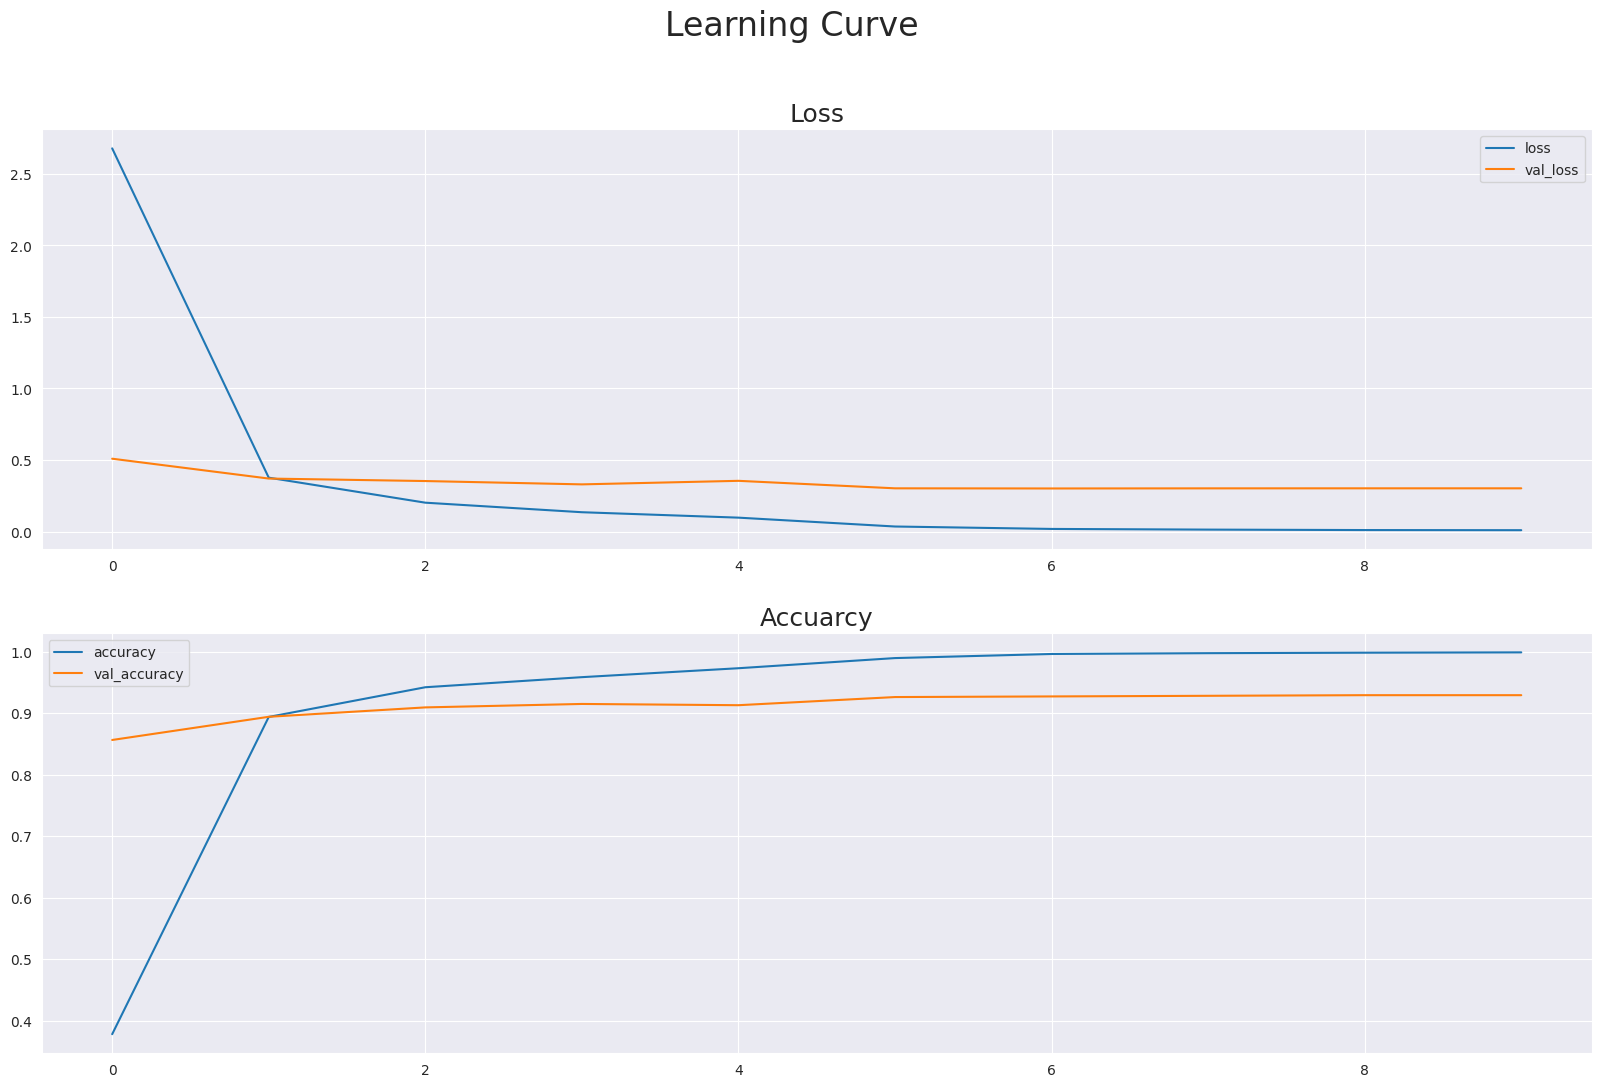

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

history = pd.DataFrame(train_history.history)
fig, ax = plt.subplots(2, 1, figsize=(20, 12))
fig.suptitle('Learning Curve', fontsize=24)
history[['loss', 'val_loss']].plot(ax=ax[0])
history[['accuracy', 'val_accuracy']].plot(ax=ax[1])
ax[0].set_title('Loss', fontsize=18)
ax[1].set_title('Accuarcy', fontsize=18);

In [55]:
y_pred = np.argmax(model.predict(test_dataset, verbose=1), axis=1)
y_pred = encoder.inverse_transform(y_pred) #vs y_test

62/62 [==============================] - 407s 6s/step


In [56]:
print("F1 Score", f1_score(y_test, y_pred, average='weighted'))

F1 Score 0.9171072887752871


In [ ]:
# # save
# model.save("classifier")
# np.save('encoder.npy', encoder.classes_)

In [38]:
# load
from transformers import TFBertModel
model = tf.keras.models.load_model("classifier", custom_objects={"TFBertModel": TFBertModel})
encoder = LabelEncoder()
encoder.classes_ = np.load('encoder.npy', allow_pickle=True)

In [64]:
df_check = \
  pd.DataFrame({'text':x_test}
      ).merge(pd.DataFrame({'label_true':y_test}), left_index=True, right_index=True
      ).merge(df_2, left_on='label_true', right_index=True
      ).merge(pd.DataFrame({'label_pred':y_pred}), left_index=True, right_index=True
      ).merge(df_2, left_on='label_pred', right_index=True )
df_check

,text,label_true,label\tintent (category)_x,label_pred,label\tintent (category)_y
0,do the details of my profile have to match my ...,69,69\tverify_my_identity,30,30\tedit_personal_details
54,Where can I edit personal details?,30,30\tedit_personal_details,30,30\tedit_personal_details
197,How do I update my address?,30,30\tedit_personal_details,30,30\tedit_personal_details
302,"got married, need to change account name",30,30\tedit_personal_details,30,30\tedit_personal_details
437,I got married and need to change my name.,30,30\tedit_personal_details,30,30\tedit_personal_details
...,...,...,...,...,...
1446,How can I find out where the funds are flow?,70,70\tverify_source_of_funds,70,70\tverify_source_of_funds
1571,Where are my funds being sourced from?,70,70\tverify_source_of_funds,70,70\tverify_source_of_funds
1633,What is the source of my funds.,70,70\tverify_source_of_funds,70,70\tverify_source_of_funds
1725,I would like to verify my source of funds.,70,70\tverify_source_of_funds,70,70\tverify_source_of_funds


In [65]:
df_check[df_check['label_true']!=df_check['label_pred']]

,text,label_true,label\tintent (category)_x,label_pred,label\tintent (category)_y
0,do the details of my profile have to match my ...,69,69\tverify_my_identity,30,30\tedit_personal_details
648,What other methods are there to verify my iden...,74,74\twhy_verify_identity,69,69\tverify_my_identity
1774,What do i need to verify my id?,68,68\tunable_to_verify_identity,69,69\tverify_my_identity
992,What do you need to verify my identity?,69,69\tverify_my_identity,74,74\twhy_verify_identity
1680,Why am I not allowed to verify my id?,68,68\tunable_to_verify_identity,74,74\twhy_verify_identity
...,...,...,...,...,...
910,Are money transfers free?,64,64\ttransfer_fee_charged,56,56\ttop_up_by_bank_transfer_charge
1135,Why am I being charged for transfers? Are they...,64,64\ttransfer_fee_charged,56,56\ttop_up_by_bank_transfer_charge
1707,Why are there additional fees for transfers?,64,64\ttransfer_fee_charged,56,56\ttop_up_by_bank_transfer_charge
1862,Do charge fees for transfers?,64,64\ttransfer_fee_charged,56,56\ttop_up_by_bank_transfer_charge


<Axes: xlabel='label_true'>

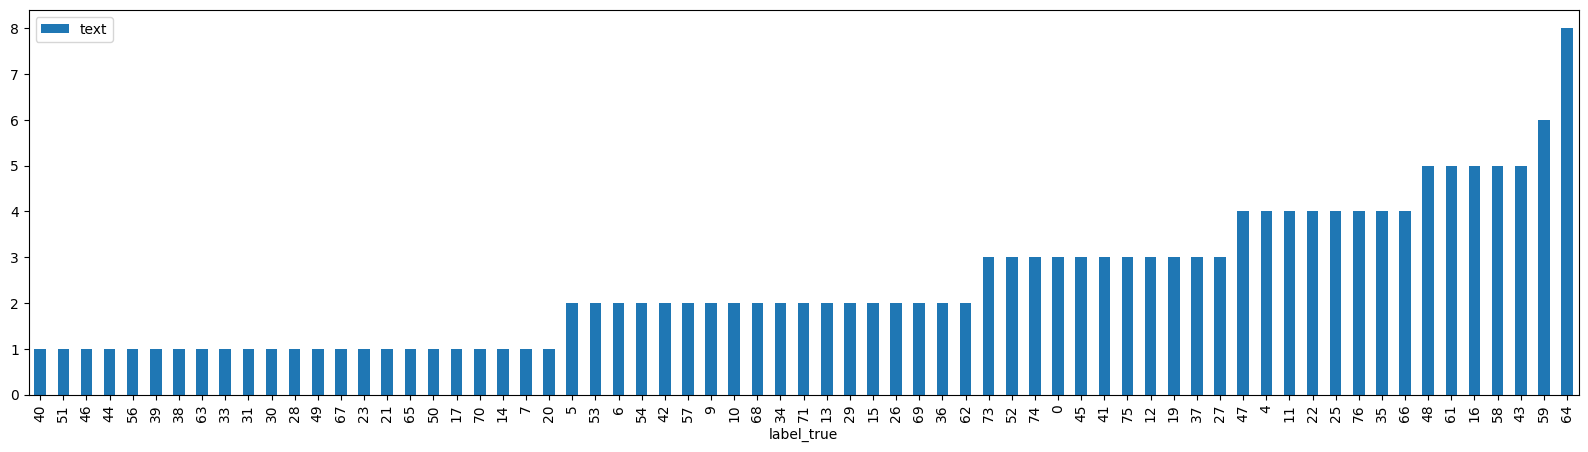

In [78]:
df = df_check[df_check['label_true']!=df_check['label_pred']]
df = df[['label_true','text']]
df.groupby(by='label_true').count().sort_values('text').plot(kind='bar', figsize=(20,5) )